### Score to Prediction
---

Often times we transform model predictions to scores for downstream tasks; once a while it would be rewarding to do so in reverse order. For example, we may transform FICO score to probabilitistic predictions for benchmarking, or Socure Sigma to a prediction that can be applied in Reject Inference - Performance Scoring.

Here let's do just that --  transform a scaled score to a probabilitistic format

Methodologies:
* get log

In [59]:
import sys, os, json
sys.path.insert(1, "../")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from ml4risk.model_selection import score_alignment as sa

%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.style.use('seaborn')

import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Get Data

In [60]:
test_df = pd.read_parquet(os.path.join("s3://sofi-data-science/Risk_DS/rdsutils_data/", "customer_baseline_n_scores.parquet"))

In [61]:
test_df.head()

,pred_incumbent,pred_wo_ind,score_incumbent,score_wo_ind,rg_incumbent,rg_wo_ind,target,fico_score,fraud_score_2
5056065,0.014803,0.048822,502.594054,540.446816,RG2,RG3,False,NaN,0.447
5056066,0.133862,0.264597,574.411334,600.448718,RG4,RG4,False,NaN,NaN
5056067,0.008159,0.012328,484.031408,496.878531,RG2,RG2,False,NaN,0.133
5056068,0.000472,0.000902,395.957985,415.952349,RG1,RG1,False,NaN,0.117
5056069,0.341065,0.239810,611.653962,596.396399,RG5,RG4,False,NaN,NaN


#### Process

* requirement: score needs to be mapped such that higher score indicates higher risk
    * e.g. swap direction for FICO
* get cumulative bad rate
* set bad rate to be the prediction
* map score to bad rate

### Produce Score Alignment based on bad rate

In [62]:
test_df[["fico_score", "pred_incumbent"]].head()

,fico_score,pred_incumbent
5056065,NaN,0.014803
5056066,NaN,0.133862
5056067,NaN,0.008159
5056068,NaN,0.000472
5056069,NaN,0.341065


In [63]:
src_pred = "fico_score_pred"
tgt_pred = "pred_incumbent"
target_col = "target"

df = test_df[test_df.fico_score.between(300, 850)]
df["fico_score_pred"] = -df["fico_score"]
df = df[["fico_score_pred", tgt_pred, target_col]].dropna()

In [64]:
df["fico_cum_br"] = sa.get_cum_bad_rate(df, src_pred, target_col)

In [65]:
br_tbl = sa.get_score_alignment_table(df, src_pred, tgt_pred, target_col,
                                      src_pred_range=(-850, -300), tgt_pred_range=(0,1),
                                   br_precision = 10, pred_precision = 10)
df[src_pred + "_rescaled"] = sa.get_aligned_score(df, br_tbl.iloc[1:], src_pred, tgt_pred,
                                                    pred_precision=10)

source column:  fico_score_pred
target columns:  pred_incumbent


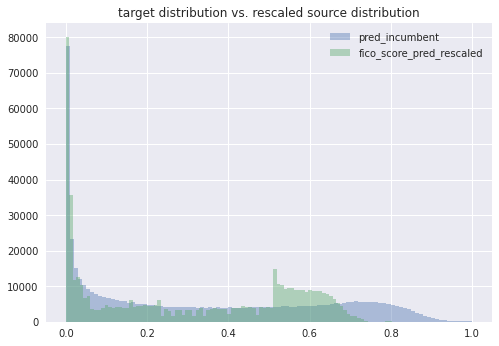

In [66]:
df[tgt_pred].hist(bins=100, alpha=0.4, label=tgt_pred)
# df[src_pred].hist(bins=100, alpha=0.4, label=src_pred)
df[src_pred+"_rescaled"].hist(bins=100, alpha=0.4, label=src_pred+"_rescaled")
plt.title("target distribution vs. rescaled source distribution")
plt.legend()

In [67]:
def build_score_coefficients(pred):
    """
    For converting probability to score ranging from 0 to 100 using this formula:

    scores = log(preds / (1 - preds)) * a + b

    Where a and b are:
    a = 100 / (max - min)
    b = - (100 * min) / max

    Where max and min are: 
    max = max(log(preds / (1 - preds)))
    min = min(log(preds / (1 - preds)))
    
    
    call a, b = build_score_coefficients(pred) 
    """
    scores = np.log(pred / (1 - pred))
    s_max = scores.max()
    s_min = scores.min()
    a = 100 / (s_max - s_min)
    b = (100 * s_min) / (s_min - s_max)
    return a, b